# Chapter 9: Classification and Regression Trees

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary


## Figure 9.7

In [52]:
Delay_df = dmba.load_data('FlightDelays.csv')
Delay_df = Delay_df.drop('DAY_OF_MONTH', axis=1)

Delay_df = Delay_df.rename(columns={'Flight Status':'Flight_Status'}) # 이름 바꾸기

Delay_df['DAY_WEEK'] = Delay_df['DAY_WEEK'].astype('category') # 범주형으로 변환
Delay_df_encoded = pd.get_dummies(Delay_df, columns=['DAY_WEEK']) # 범주값을 이진변수로
# Delay_df_encoded = pd.get_dummies(Delay_df, columns=['DAY_WEEK', 'Flight_Status']) # 범주값을 이진변수로

In [53]:
Delay_df['DEST'] = Delay_df['DEST'].astype('category') # 범주형으로 변환
Delay_df_encoded = pd.get_dummies(Delay_df, columns=['DEST']) # 범주값을 이진변수로

In [55]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=8) # 최대 깊이 8
classTree.fit(Delay_df.drop(columns=['Flight_Status']), Delay_df['Flight_Status']) 

ValueError: could not convert string to float: 'OH'

In [41]:
print("Classes: {}".format(', '.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names=Delay_df.columns[:12], class_names=classTree.classes_)

ValueError: could not convert string to float: 'OH'

The order of the `values` vector in the boxes is the same as `classTree.classes_`.

## Figure 9.8
Grow tree fully

In [31]:
classTree = DecisionTreeClassifier(random_state=0)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])

print("Classes: {}".format(', '.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names=mower_df.columns[:10], class_names=classTree.classes_)

Classes: Nonowner, Owner


ValueError: Length of feature_names, 3 does not match number of features, 2

## Figure 9.10

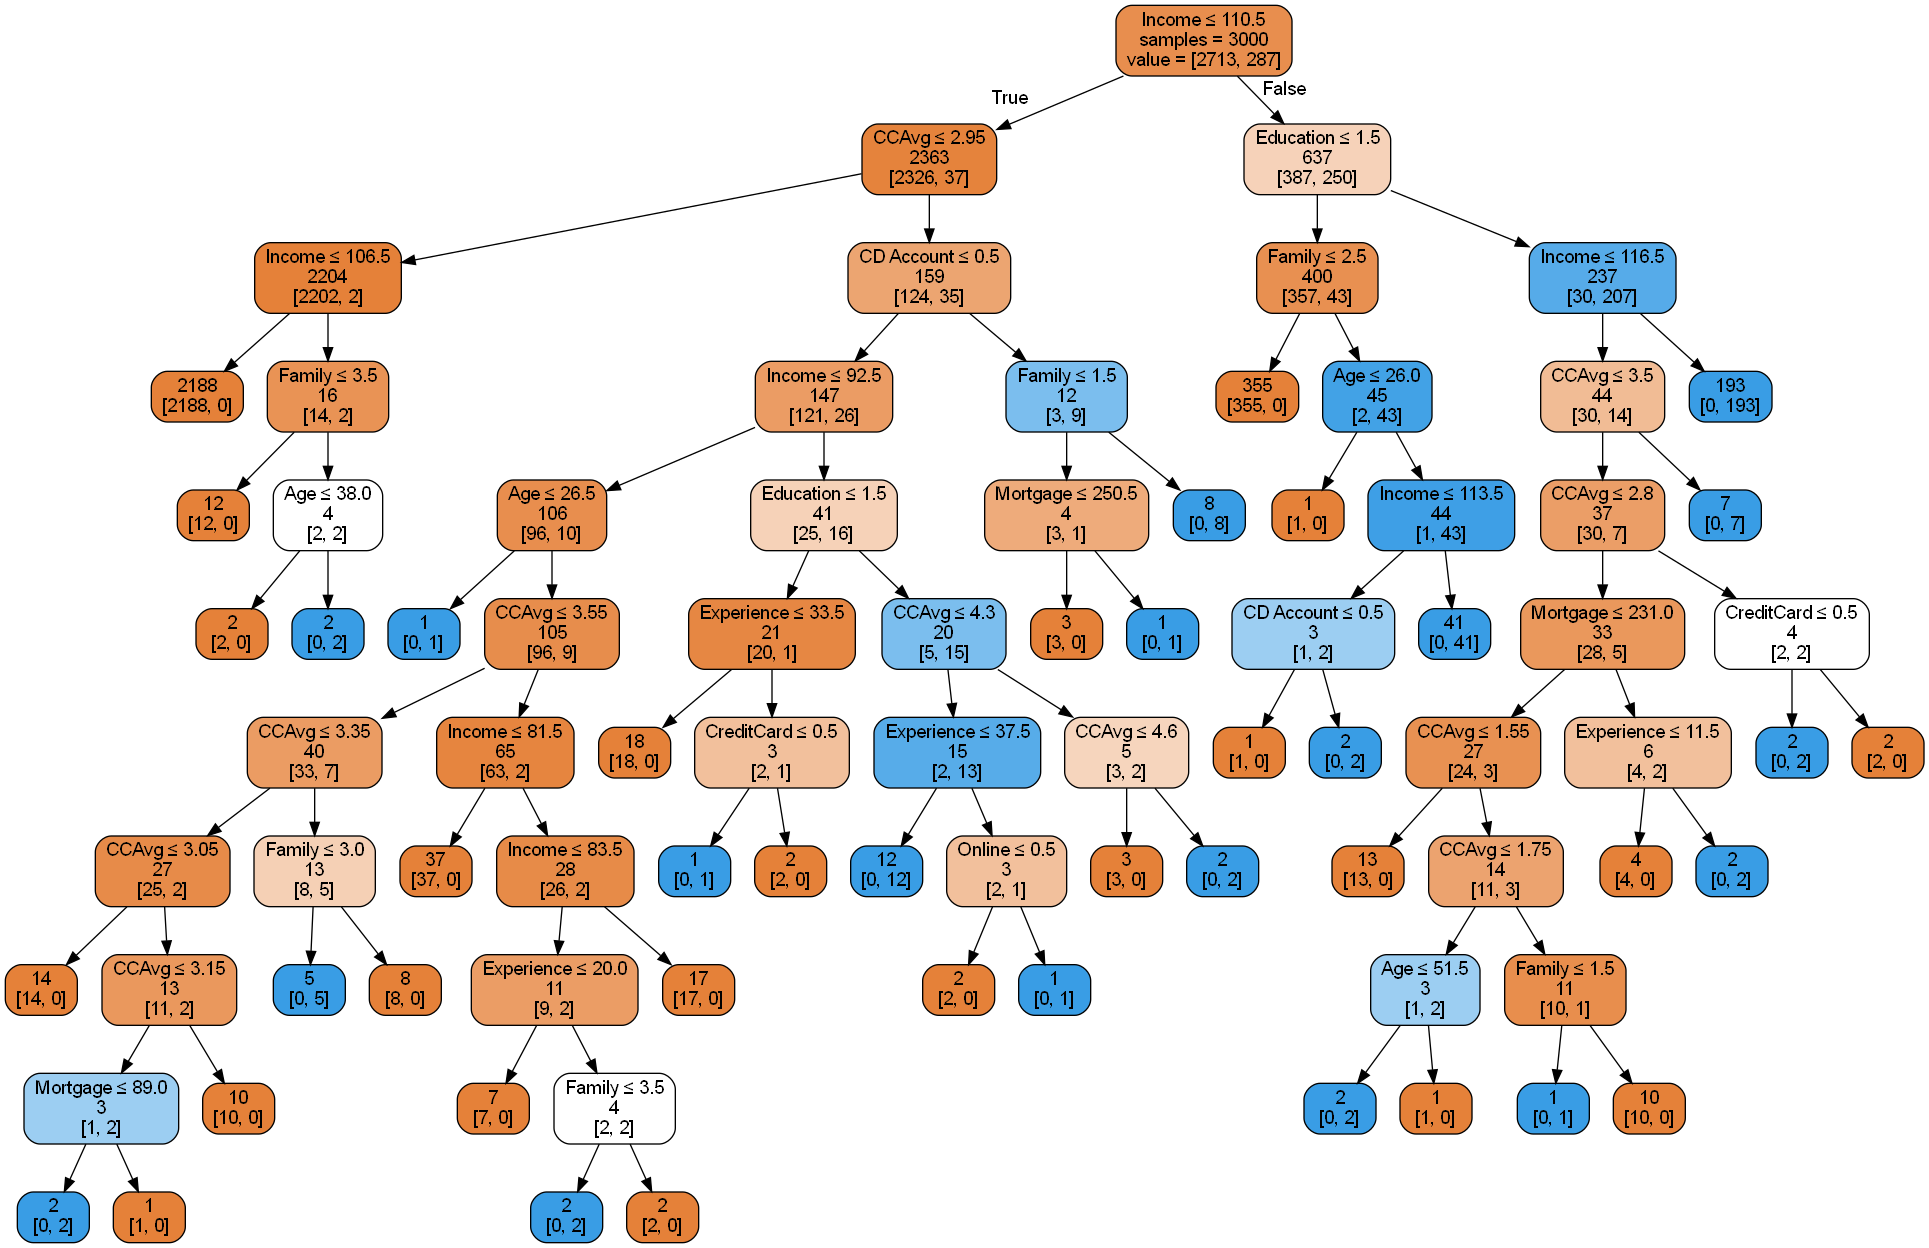

In [4]:
bank_df = dmba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

## Table 9.3
<!-- <div class='alert alert-danger'>R output for reference - remove once missing metrics are available.
```
> confusionMatrix(default.ct.point.pred.train, train.df$Personal.Loan)
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2696   26
         1   13  265
                                          
               Accuracy : 0.987           
                 95% CI : (0.9823, 0.9907)
    No Information Rate : 0.903           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9243          
 Mcnemar's Test P-Value : 0.05466         
                                          
            Sensitivity : 0.9952          
            Specificity : 0.9107          
         Pos Pred Value : 0.9904          
         Neg Pred Value : 0.9532          
             Prevalence : 0.9030          
         Detection Rate : 0.8987          
   Detection Prevalence : 0.9073          
      Balanced Accuracy : 0.9529          
                                          
       'Positive' Class : 0               
```
</div>-->

In [5]:
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2713    0
     1    0  287
Confusion Matrix (Accuracy 0.9805)

       Prediction
Actual    0    1
     0 1794   13
     1   26  167


## Table 9.4

In [6]:
# Five-fold cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.988', '0.972', '0.992', '0.987', '0.993']
Accuracy: 0.986 (+/- 0.015)
Accuracy: 0.986 (+/- 0.008)


## Figure 9.12

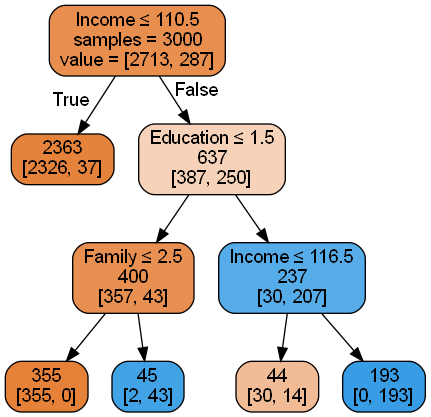

In [7]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

## Table 9.5

In [8]:
classificationSummary(train_y, smallClassTree.predict(train_X))
classificationSummary(valid_y, smallClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9823)

       Prediction
Actual    0    1
     0 2711    2
     1   51  236
Confusion Matrix (Accuracy 0.9770)

       Prediction
Actual    0    1
     0 1804    3
     1   43  150


## Grid search

## Table 9.6

In [9]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.9876666666666667
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved score:  0.9873333333333333
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.0011, 'min_samples_split': 13}


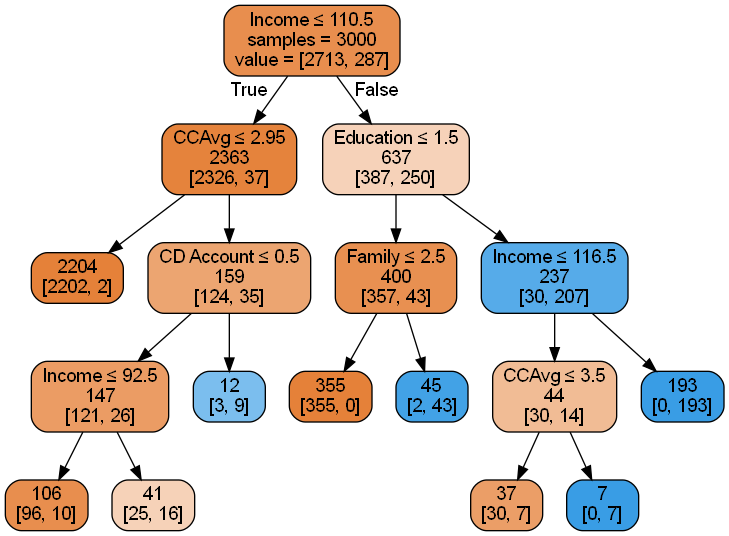

In [10]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

In [11]:
classificationSummary(train_y, bestClassTree.predict(train_X))
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9867)

       Prediction
Actual    0    1
     0 2708    5
     1   35  252
Confusion Matrix (Accuracy 0.9815)

       Prediction
Actual    0    1
     0 1801    6
     1   31  162


## Figure 9.16

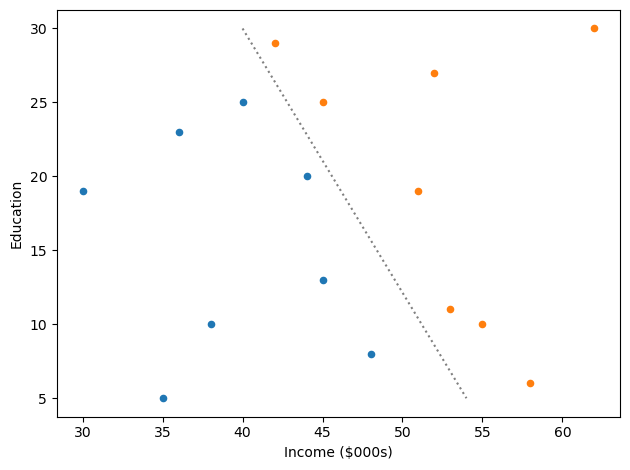

In [12]:
fakeScatter = pd.DataFrame([
    (30, 19, 1), (35, 5, 1), (40, 25, 1), (45, 13, 1), 
    (38, 10, 1), (36, 23, 1), (48, 8, 1), (44, 20, 1), (50, 12),
    (51, 19, 0), (62, 30, 0), (42, 29, 0), (45, 25, 0), 
    (55, 10, 0), (52, 27, 0), (58, 6, 0), (53, 11, 0), 
], columns=['x', 'y', 'category'])
ax = fakeScatter.loc[fakeScatter.category==1,:].plot.scatter(x='x', y='y', color='C0')
fakeScatter.loc[fakeScatter.category==0,:].plot.scatter(x='x', y='y', ax=ax, color='C1')
plt.plot((40, 54), (30, 5), ':', color='grey')
ax.set_xlabel('Income ($000s)')
ax.set_ylabel('Education')

plt.tight_layout()
plt.show()

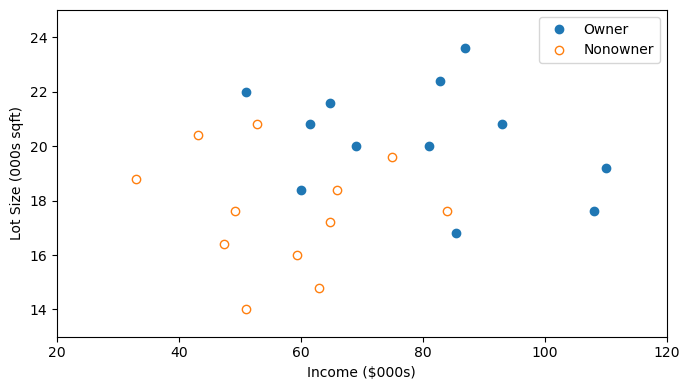

In [13]:
def basePlot(ax):
    mower_df.loc[mower_df.Ownership=='Owner'].plot(x='Income', y='Lot_Size', style='o', 
                                                   markerfacecolor='C0', markeredgecolor='C0',
                                                   ax=ax)
    mower_df.loc[mower_df.Ownership=='Nonowner'].plot(x='Income', y='Lot_Size', style='o',
                                                      markerfacecolor='none', markeredgecolor='C1',
                                                      ax=ax)
    ax.legend(["Owner", "Nonowner"]);
    ax.set_xlim(20, 120)
    ax.set_ylim(13, 25)
    ax.set_xlabel('Income ($000s)')
    ax.set_ylabel('Lot Size (000s sqft)')
    return ax

fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
plt.tight_layout()
plt.show()

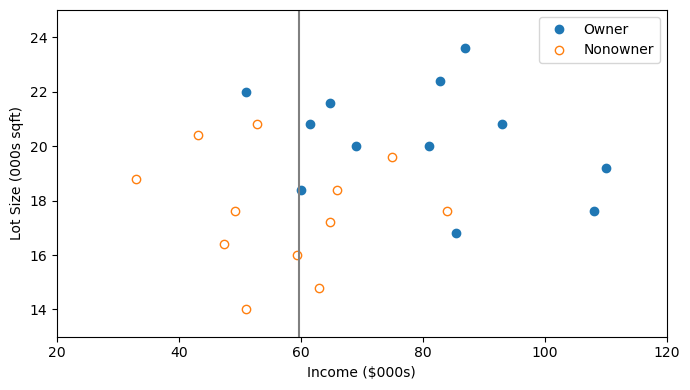

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
ax.plot((x0, x0), (25, 13), color='grey')
plt.tight_layout()
plt.show()

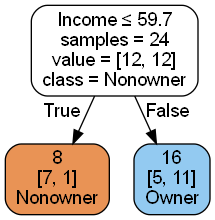

In [15]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

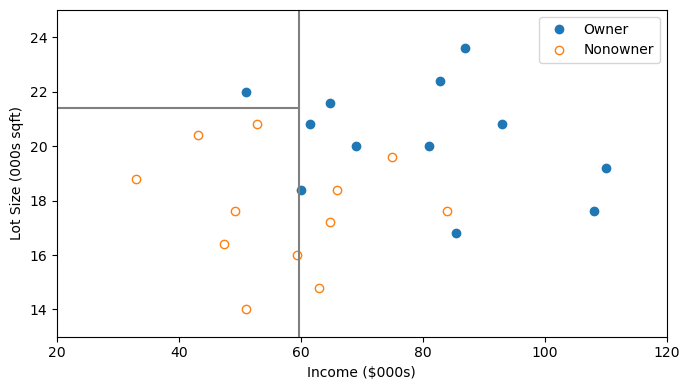

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
plt.tight_layout()
plt.show()

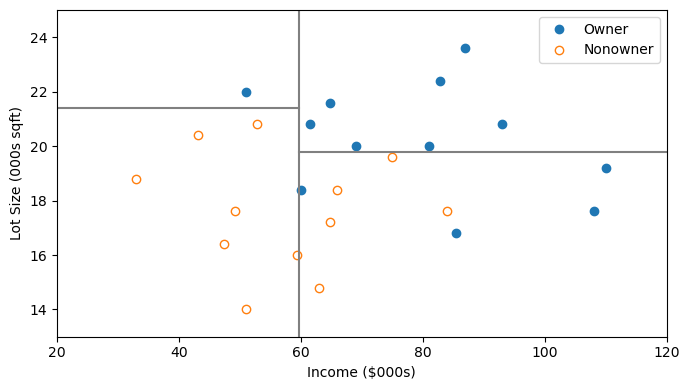

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
plt.tight_layout()
plt.show()

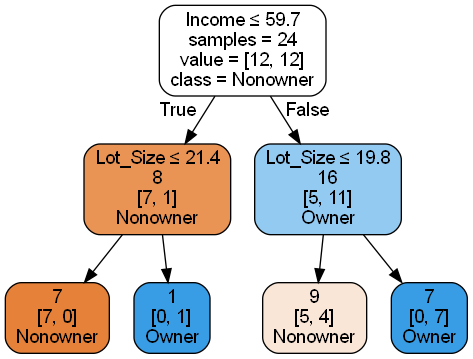

In [18]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=2)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

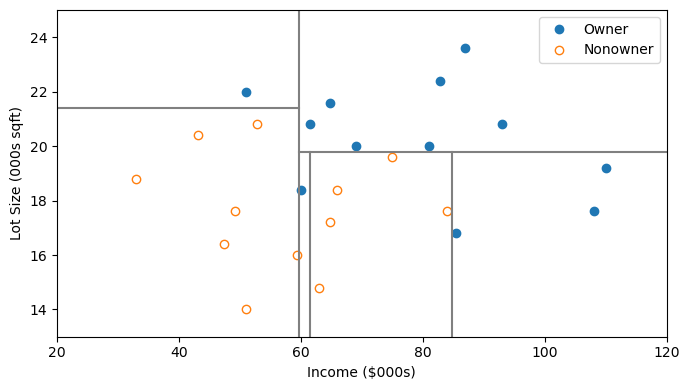

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))

ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
x3 = 84.75
x4 = 61.5
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
ax.plot((x3, x3), (13, y2), color='grey')
ax.plot((x4, x4), (13, y2), color='grey')
plt.tight_layout()
plt.show()

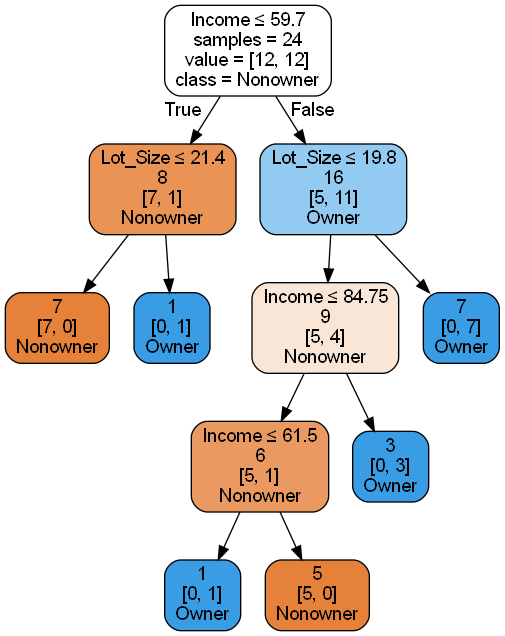

In [20]:
classTree = DecisionTreeClassifier(random_state=0)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plotDecisionTree(classTree, feature_names=mower_df.columns[:2], class_names=classTree.classes_)

## Information about full decision tree

In [21]:
tree = fullClassTree
print('Number of nodes', tree.tree_.node_count)

Number of nodes 85


In [22]:
estimator = tree
# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
value = estimator.tree_.value


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

from collections import Counter
nodeClassCounter = Counter()
terminal_leaves = 0
for i in range(n_nodes):
    if is_leaves[i]:
        terminal_leaves = terminal_leaves + 1
        nodeClassCounter.update([np.argmax(value[i][0])])
print()
print('Number of terminal leaves', terminal_leaves)
print(nodeClassCounter)


Number of terminal leaves 43
Counter({0: 24, 1: 19})


## Regression Trees : Table 9.7 and Figure 9.14

In [23]:
toyotaCorolla_df = dmba.load_data('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008], 
    'min_samples_split': [14, 15, 16, 18, 20, ], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

regTree = gridSearch.best_estimator_

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 16}


In [24]:
regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1058.8202
            Mean Absolute Error (MAE) : 767.7203
          Mean Percentage Error (MPE) : -0.8074
Mean Absolute Percentage Error (MAPE) : 6.8325

Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
          Mean Percentage Error (MPE) : -1.3082
Mean Absolute Percentage Error (MAPE) : 9.2311


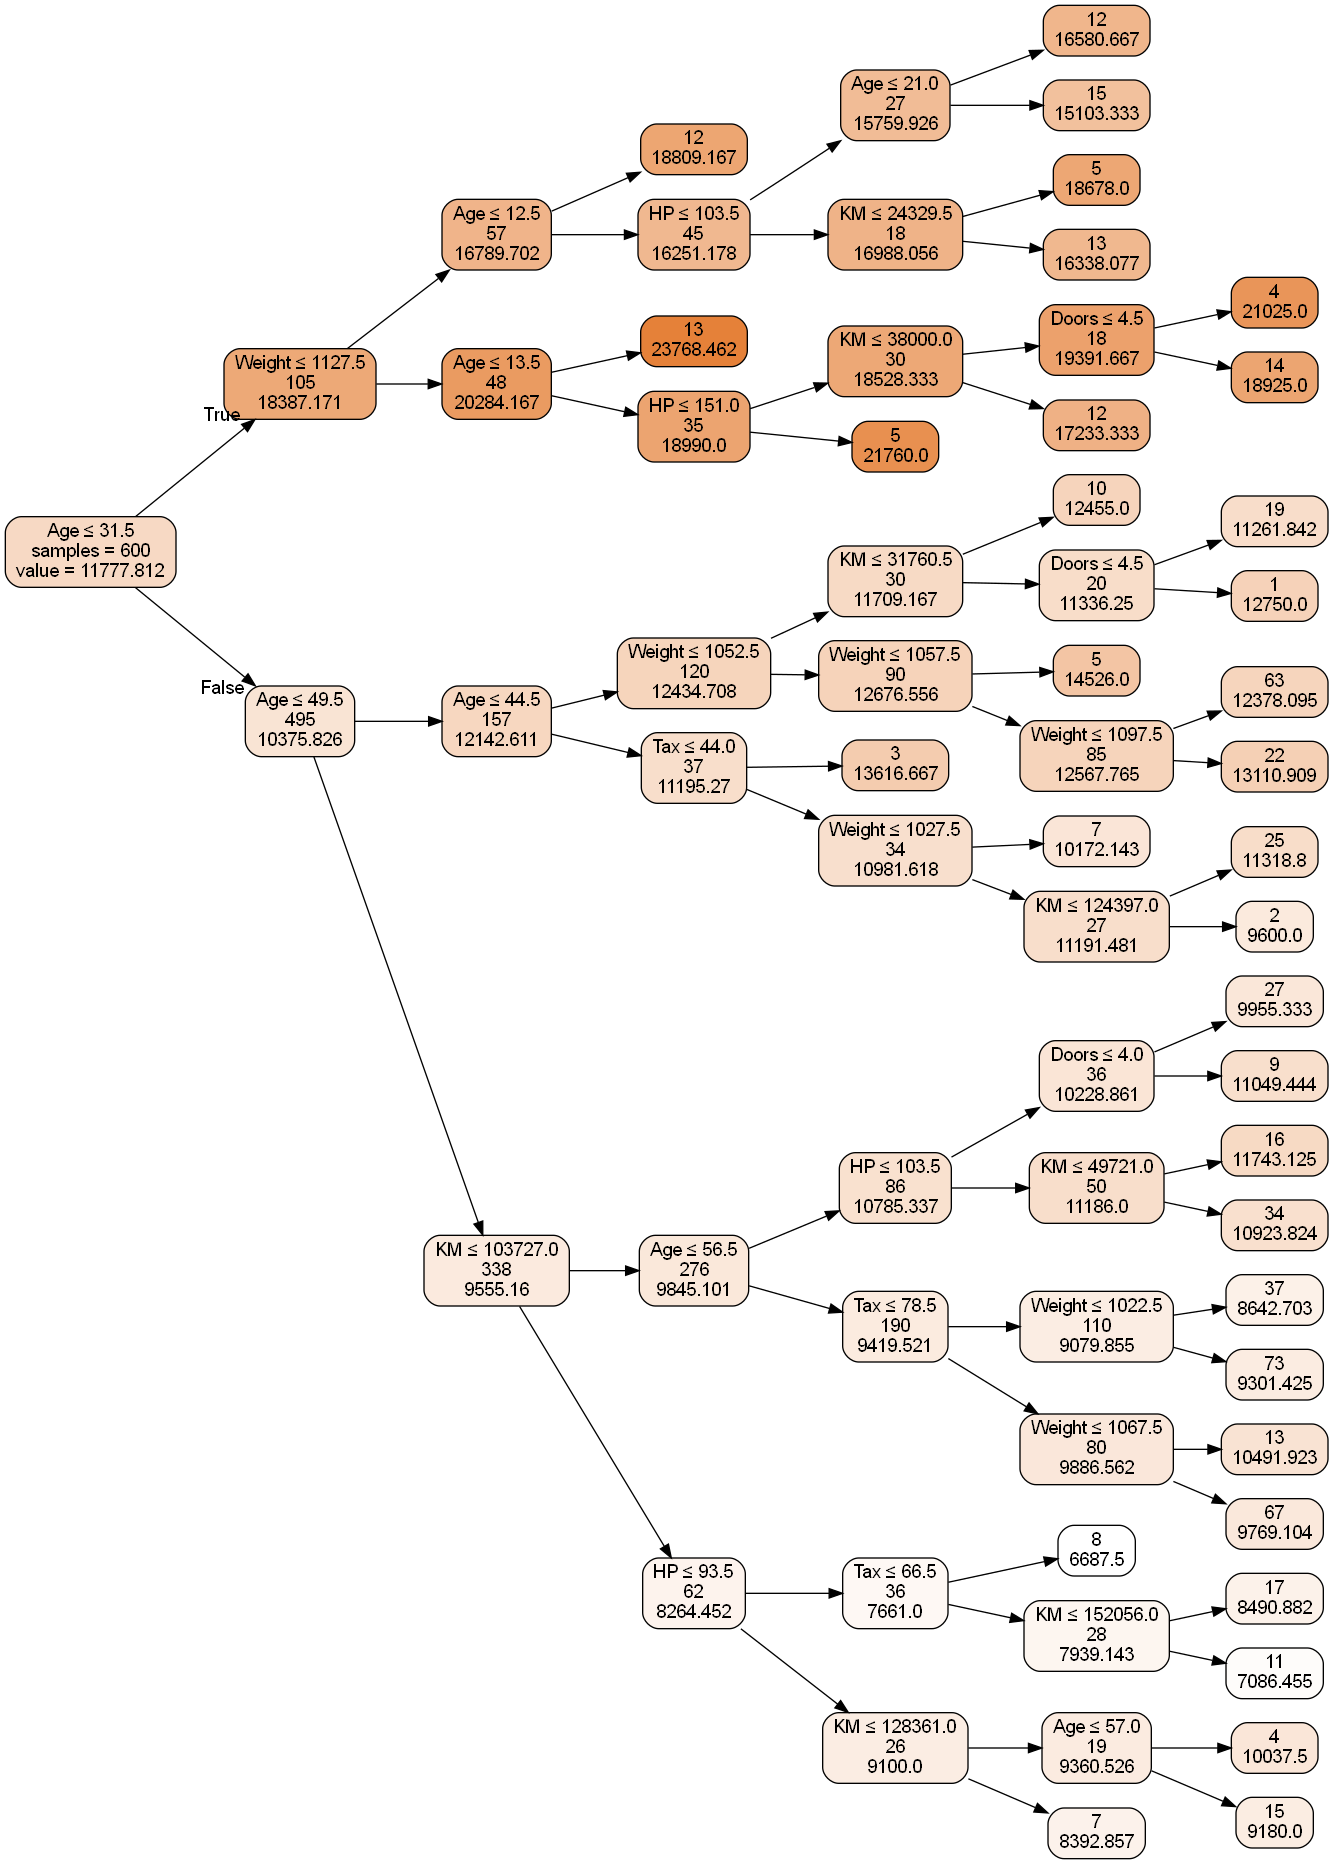

In [25]:
plotDecisionTree(regTree, feature_names=train_X.columns)
plotDecisionTree(regTree, feature_names=train_X.columns, rotate=True)

## Figure 9.15 (no longer used)

In [26]:
bank_df = dmba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

Variable importance plot

               feature  importance       std
7   Securities Account    0.003964  0.004998
9               Online    0.006394  0.005350
10          CreditCard    0.007678  0.007053
6             Mortgage    0.034243  0.023469
1           Experience    0.035539  0.016061
0                  Age    0.036258  0.015858
8           CD Account    0.057917  0.043185
3               Family    0.111375  0.053146
4                CCAvg    0.172105  0.103011
5            Education    0.200772  0.101002
2               Income    0.333756  0.129227


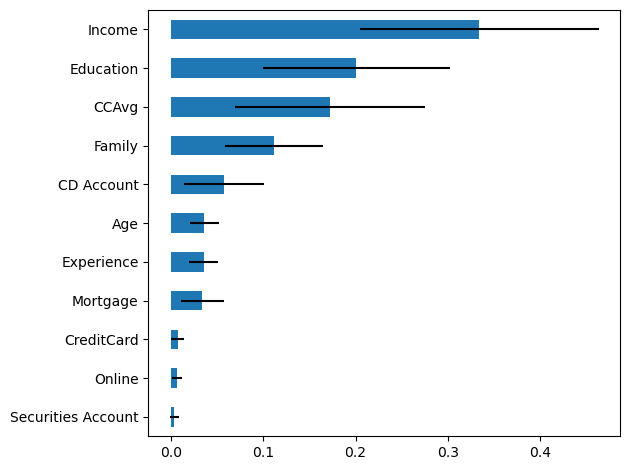

In [27]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

Confusion matrix and metrics

In [28]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161


## Table 9.5

In [29]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.9835)

       Prediction
Actual    0    1
     0 1799    8
     1   25  168
